# Python Stats #2 : Case study

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [ ]:
"""
# Data Loading
f_list = ['/Users/Danny/Downloads/archive/finch_beaks_1975.csv', '/Users/Danny/Downloads/archive/finch_beaks_2012.csv']
df_list = [pd.read_csv(f) for f in f_list]
df = \
    (pd.concat(df_list)
    .query('species == "scandens"')
    .assign(year = lambda x : np.where(x['bdepth'].isna(), '1975', '2012'))
    .assign(beak_depth = lambda x : np.where(x['bdepth'].isna(), x['Beak depth, mm'], x['bdepth']))
    .assign(beak_length = lambda x : np.where(x['blength'].isna(), x['Beak length, mm'], x['blength']))
    .loc[:,['beak_depth', 'beak_length', 'year']]
    )
df.to_csv('/Users/Danny/Documents/Learning/dataset/finch_beaks.csv', index=False)
"""

In [28]:
df = pd.read_csv('../dataset/finch_beaks.csv').loc[:, ['beak_depth', 'year']]
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(shape=size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

## Univariate analysis
- EDA
- Confidence on estimator
- Hypothesis test on estimator

### EDA

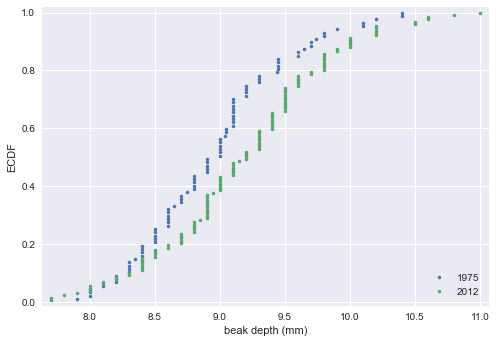

In [29]:
bd_1975 = df.loc[df['year'] == 1975, 'beak_depth'].to_numpy()
bd_2012 = df.loc[df['year'] == 2012, 'beak_depth'].to_numpy()

# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
plt.plot(x_1975, y_1975, marker='.', linestyle='none')
plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
plt.xlabel('beak depth (mm)')
plt.ylabel('ECDF')
plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

### Differnce mean from 2 group : bootstraping to find confidence interval

In [43]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.06367522 0.3896871 ] mm


### Hypothesis testing : Difference in mean caused by chance of sample
Key Takeaway  
The hypothesis we are testing is not that the beak depths come from the same distribution. For that we could use a permutation test. The hypothesis is that the means are equal. To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.

In [44]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)


p = 0.0031


We get a p-value of 0.0034, which suggests that there is a statistically significant difference. But remember: it is very important to know how different they are! In the previous exercise, you got a difference of 0.2 mm between the means. You should combine this with the statistical significance. Changing by 0.2 mm in 37 years is substantial by evolutionary standards. If it kept changing at that rate, the beak depth would double in only 400 years.

### `To-do` Use statistical method to find conf interval
Null hypothesis : u2012 - u1975 = 0  
Alternate hypothesis : u2012 - u1975 != 0

In [23]:
# Statistical method : scipy/numpy
# based on https://machinelearningmastery.com/parametric-statistical-significance-tests-in-python/
# code from https://stats.stackexchange.com/questions/475289/confidence-interval-for-2-sample-t-test-with-scipy
# welch vs t-test from http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html

import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import t
import pandas as pd

def ttest_diff_mean(x1, x2, equal_var=False):
    """2 side T-test difference of mean between 2 groups sample data"""
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    
    if equal_var: # Not finish
        # standard error (se) : equal varience (t-test), use pooled se
        se = ((n1 - 1)*v1 + (n2 - 1)*v2) / (n1 + n2 - 2)*np.sqrt((1 / n1) + (1 / n2))
        # For equal varience : DF = n1+n2-2
        df = n1 + n2 - 2
    else:
        # standard error (se) : unequal varience (welch's t-test)
        se = np.sqrt(v1 / n1 + v2 / n2)
        # Degree of freedom (ddof), for unequal varience 
        df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))

    delta = m1-m2
    tstat = delta / se

    # two side t-test
    p = 2 * t.cdf(-abs(tstat), df)
    
    # upper and lower bounds
    lb = delta - t.ppf(0.975,df)*se 
    ub = delta + t.ppf(0.975,df)*se
  
    return pd.DataFrame(np.array([str(equal_var), tstat,df,p,delta,lb,ub]).reshape(1,-1),
                         columns=['Equal varience','T statistic','df','pvalue 2 sided','Difference in mean','lb','ub'])

In [24]:
ttest_diff_mean(bd_2012, bd_1975)

,Equal varience,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,False,2.662956854358034,202.61825878505712,0.008368168999281883,0.22622047244094645,0.058719369963416396,0.3937215749184765


In [25]:
ttest_ind(bd_2012, bd_1975, equal_var=False, alternative='two-sided')

Ttest_indResult(statistic=2.662956854358034, pvalue=0.008368168999281883)

## Bi-variate analysis



In [49]:
df = pd.read_csv('../dataset/finch_beaks.csv')
bd_1975 = df.loc[df['year'] == 1975, 'beak_depth'].to_numpy()
bd_2012 = df.loc[df['year'] == 2012, 'beak_depth'].to_numpy()
bl_1975 = df.loc[df['year'] == 1975, 'beak_length'].to_numpy()
bl_2012 = df.loc[df['year'] == 2012, 'beak_length'].to_numpy()

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(x))
    
    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, deg=1)

    return bs_slope_reps, bs_intercept_reps

### EDA

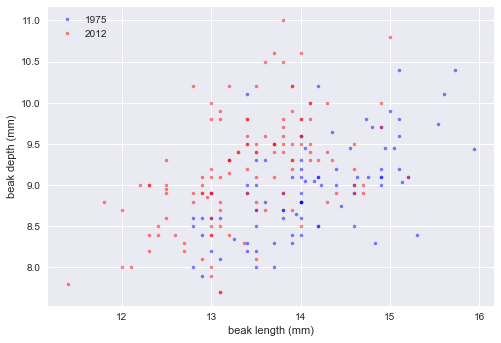

In [48]:
# Make scatter plot of 1975 data
plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
plt.plot(bl_2012, bd_2012, marker='.',
            linestyle='None', color='red', alpha=0.5)

# Label axes and make legend
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

### Linear Regression , bootstrap to get confidence interval

In [50]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, deg=1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, deg=1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, size=1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, size=1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])

# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.32895183 0.59435107]
1975: intercept = 2.3908752365842267 conf int = [0.57216906 4.34085464]
2012: slope = 0.462630358835313 conf int = [0.33202634 0.60168063]
2012: intercept = 2.9772474982360198 conf int = [1.14207797 4.74021368]


Nicely done! It looks like they have the same slope, but different intercepts.  
Let's EDA for slope/intercep for bootstrap linear regression

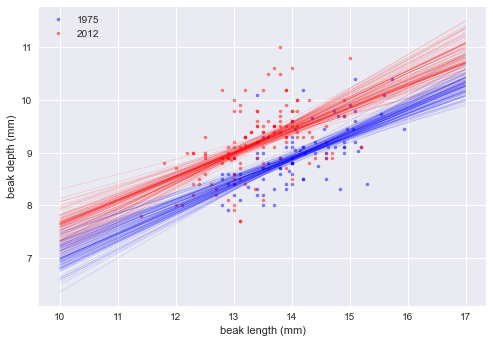

In [51]:
# Make scatter plot of 1975 data
plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

The linear regressions showed interesting information about the beak geometry. The slope was the same in 1975 and 2012, suggesting that for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years. However, if we are interested in the shape of the beak, we want to compare the ratio of beak length to beak depth. Let's make that comparison.

In [52]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975/bd_1975
ratio_2012 = bl_2012/bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 conf int = [1.55669512 1.60146439]
2012: mean ratio = 1.4658342276847767 conf int = [1.44365326 1.48780844]


## Cross species investigation

In [62]:
s_here = pd.read_csv('/Users/Danny/Downloads/archive/scandens_beak_depth_heredity.csv')
bd_parent_scandens = s_here['mid_parent'].to_numpy()
bd_offspring_scandens = s_here['mid_offspring'].to_numpy()
f_here = pd.read_csv('/Users/Danny/Downloads/archive/fortis_beak_depth_heredity.csv')
bd_offspring_fortis = f_here['Mid-offspr'].to_numpy()

bd_parent_fortis = np.array([10.1  ,  9.55 ,  9.4  , 10.25 , 10.125,  9.7  ,  9.05 ,  7.4  ,
        9.   ,  8.65 ,  9.625,  9.9  ,  9.55 ,  9.05 ,  8.35 , 10.1  ,
       10.1  ,  9.9  , 10.225, 10.   , 10.55 , 10.45 ,  9.2  , 10.2  ,
        8.95 , 10.05 , 10.2  ,  9.5  ,  9.925,  9.95 , 10.05 ,  8.75 ,
        9.2  , 10.15 ,  9.8  , 10.7  , 10.5  ,  9.55 , 10.55 , 10.475,
        8.65 , 10.7  ,  9.1  ,  9.4  , 10.3  ,  9.65 ,  9.5  ,  9.7  ,
       10.525,  9.95 , 10.1  ,  9.75 , 10.05 ,  9.9  , 10.   ,  9.1  ,
        9.45 ,  9.25 ,  9.5  , 10.   , 10.525,  9.9  , 10.4  ,  8.95 ,
        9.4  , 10.95 , 10.75 , 10.1  ,  8.05 ,  9.1  ,  9.55 ,  9.05 ,
       10.2  , 10.   , 10.55 , 10.75 ,  8.175,  9.7  ,  8.8  , 10.75 ,
        9.3  ,  9.7  ,  9.6  ,  9.75 ,  9.6  , 10.45 , 11.   , 10.85 ,
       10.15 , 10.35 , 10.4  ,  9.95 ,  9.1  , 10.1  ,  9.85 ,  9.625,
        9.475,  9.   ,  9.25 ,  9.1  ,  9.25 ,  9.2  ,  9.95 ,  8.65 ,
        9.8  ,  9.4  ,  9.   ,  8.55 ,  8.75 ,  9.65 ,  8.95 ,  9.15 ,
        9.85 , 10.225,  9.825, 10.   ,  9.425, 10.4  ,  9.875,  8.95 ,
        8.9  ,  9.35 , 10.425, 10.   , 10.175,  9.875,  9.875,  9.15 ,
        9.45 ,  9.025,  9.7  ,  9.7  , 10.05 , 10.3  ,  9.6  , 10.   ,
        9.8  , 10.05 ,  8.75 , 10.55 ,  9.7  , 10.   ,  9.85 ,  9.8  ,
        9.175,  9.65 ,  9.55 ,  9.9  , 11.55 , 11.3  , 10.4  , 10.8  ,
        9.8  , 10.45 , 10.   , 10.75 ,  9.35 , 10.75 ,  9.175,  9.65 ,
        8.8  , 10.55 , 10.675,  9.95 ,  9.55 ,  8.825,  9.7  ,  9.85 ,
        9.8  ,  9.55 ,  9.275, 10.325,  9.15 ,  9.35 ,  9.15 ,  9.65 ,
       10.575,  9.975,  9.55 ,  9.2  ,  9.925,  9.2  ,  9.3  ,  8.775,
        9.325,  9.175,  9.325,  8.975,  9.7  ,  9.5  , 10.225, 10.025,
        8.2  ,  8.2  ,  9.55 ,  9.05 ,  9.6  ,  9.6  , 10.15 ,  9.875,
       10.485, 11.485, 10.985,  9.7  ,  9.65 ,  9.35 , 10.05 , 10.1  ,
        9.9  ,  8.95 ,  9.3  ,  9.95 ,  9.45 ,  9.5  ,  8.45 ,  8.8  ,
        8.525,  9.375, 10.2  ,  7.625,  8.375,  9.25 ,  9.4  , 10.55 ,
        8.9  ,  8.8  ,  9.   ,  8.575,  8.575,  9.6  ,  9.375,  9.6  ,
        9.95 ,  9.6  , 10.2  ,  9.85 ,  9.625,  9.025, 10.375, 10.25 ,
        9.3  ,  9.5  ,  9.55 ,  8.55 ,  9.05 ,  9.9  ,  9.8  ,  9.75 ,
       10.25 ,  9.1  ,  9.65 , 10.3  ,  8.9  ,  9.95 ,  9.5  ,  9.775,
        9.425,  7.75 ,  7.55 ,  9.1  ,  9.6  ,  9.575,  8.95 ,  9.65 ,
        9.65 ,  9.65 ,  9.525,  9.85 ,  9.05 ,  9.3  ,  8.9  ,  9.45 ,
       10.   ,  9.85 ,  9.25 , 10.1  ,  9.125,  9.65 ,  9.1  ,  8.05 ,
        7.4  ,  8.85 ,  9.075,  9.   ,  9.7  ,  8.7  ,  9.45 ,  9.7  ,
        8.35 ,  8.85 ,  9.7  ,  9.45 , 10.3  , 10.   , 10.45 ,  9.45 ,
        8.5  ,  8.3  , 10.   ,  9.225,  9.75 ,  9.15 ,  9.55 ,  9.   ,
        9.275,  9.35 ,  8.95 ,  9.875,  8.45 ,  8.6  ,  9.7  ,  8.55 ,
        9.05 ,  9.6  ,  8.65 ,  9.2  ,  8.95 ,  9.6  ,  9.15 ,  9.4  ,
        8.95 ,  9.95 , 10.55 ,  9.7  ,  8.85 ,  8.8  , 10.   ,  9.05 ,
        8.2  ,  8.1  ,  7.25 ,  8.3  ,  9.15 ,  8.6  ,  9.5  ,  8.05 ,
        9.425,  9.3  ,  9.8  ,  9.3  ,  9.85 ,  9.5  ,  8.65 ,  9.825,
        9.   , 10.45 ,  9.1  ,  9.55 ,  9.05 , 10.   ,  9.35 ,  8.375,
        8.3  ,  8.8  , 10.1  ,  9.5  ,  9.75 , 10.1  ,  9.575,  9.425,
        9.65 ,  8.725,  9.025,  8.5  ,  8.95 ,  9.3  ,  8.85 ,  8.95 ,
        9.8  ,  9.5  ,  8.65 ,  9.1  ,  9.4  ,  8.475,  9.35 ,  7.95 ,
        9.35 ,  8.575,  9.05 ,  8.175,  9.85 ,  7.85 ,  9.85 , 10.1  ,
        9.35 ,  8.85 ,  8.75 ,  9.625,  9.25 ,  9.55 , 10.325,  8.55 ,
        9.675,  9.15 ,  9.   ,  9.65 ,  8.6  ,  8.8  ,  9.   ,  9.95 ,
        8.4  ,  9.35 , 10.3  ,  9.05 ,  9.975,  9.975,  8.65 ,  8.725,
        8.2  ,  7.85 ,  8.775,  8.5  ,  9.4  ])

### EDA

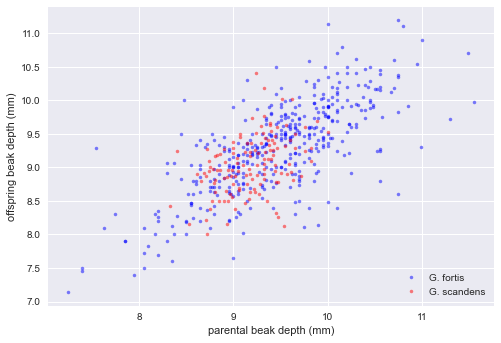

In [64]:
# Make scatter plots
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes
_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')

# Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

# Show plot
plt.show()


It appears as though there is a stronger correlation in G. fortis than in G. scandens. This suggests that beak depth is more strongly inherited in G. fortis. We'll quantify this correlation next.

In an effort to quantify the correlation between offspring and parent beak depths, we would like to compute statistics, such as the Pearson correlation coefficient, between parents and offspring. To get confidence intervals on this, we need to do a pairs bootstrap.

Make a new function with call signature draw_bs_pairs(x, y, func, size=1) that performs pairs bootstrap and computes a single statistic on pairs samples defined. The statistic of interest is computed by calling func(bs_x, bs_y). In the next exercise, you will use pearson_r for func.

In [65]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [67]:
# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens, pearson_r, 1000)
bs_replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis, pearson_r, 1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)

G. scandens: 0.4117063629401258 [0.27393655 0.53845645]
G. fortis: 0.7283412395518486 [0.66631053 0.78040898]


It is clear from the confidence intervals that beak depth of the offspring of G. fortis parents is more strongly correlated with their offspring than their G. scandens counterparts.

Remember that the Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets. This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability. If we stop and think, it makes more sense to define heritability as the ratio of the covariance between parent and offspring to the variance of the parents alone. In this exercise, you will estimate the heritability and perform a pairs bootstrap calculation to get the 95% confidence interval.

This exercise highlights a very important point. Statistical inference (and data analysis in general) is not a plug-n-chug enterprise. You need to think carefully about the questions you are seeking to answer with your data and analyze them appropriately. If you are interested in how heritable traits are, the quantity we defined as the heritability is more apt than the off-the-shelf statistic, the Pearson correlation coefficient.

In [68]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
        
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)


G. scandens: 0.5485340868685982 [0.35322741 0.74815791]
G. fortis: 0.7229051911438155 [0.65164321 0.79709321]


Here again, we see that G. fortis has stronger heritability than G. scandens. This suggests that the traits of G. fortis may be strongly incorporated into G. scandens by introgressive hybridization.

The heritability of beak depth in G. scandens seems low. It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species. You will test that hypothesis here. To do this, you will do a pairs permutation test.

In [69]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted, bd_offspring_scandens)


# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# Print the p-value
print('p-val =', p)


p-val = 0.0


You get a p-value of zero, which means that none of the 10,000 permutation pairs replicates you drew had a heritability high enough to match that which was observed. This strongly suggests that beak depth is heritable in G. scandens, just not as much as in G. fortis. If you like, you can plot a histogram of the heritability replicates to get a feel for how extreme of a value of heritability you might expect by chance.